In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings(action = 'ignore')

In [63]:
pima_df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Replacing 0 values in some columns with np.nan as they can't be 0.

In [64]:
pima_df.iloc[:, 1 : -1] = pima_df.iloc[:, 1 : -1].replace(0, np.nan)

In [65]:
pima_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# Using Simple Imputer to Impute Missing Values

In [66]:
def SimpleImp(df, stra):
    df = df.copy()
    imputer = SimpleImputer(strategy = stra)
    df1 = imputer.fit_transform(df)
    df1 = pd.DataFrame(df1, columns = df.columns, index = df.index)
    # Model Building
    x_train, x_test, y_train, y_test = train_test_split(df1.iloc[:, 0 : -1], df1.iloc[:, -1],test_size = 0.30, shuffle = True, random_state  = 1)
    model = LogisticRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print('Accuracy Score : {:.3f}%'.format(model.score(x_test, y_test)*100))
    print('Confusion Matrix :\n {}'.format(confusion_matrix(y_test, y_pred)))
    

### Strategy = Median

In [67]:
 SimpleImp(pima_df, 'median')

Accuracy Score : 77.489%
Confusion Matrix :
 [[131  15]
 [ 37  48]]


### Strategy = Mean

In [68]:
 SimpleImp(pima_df, 'mean')

Accuracy Score : 77.922%
Confusion Matrix :
 [[131  15]
 [ 36  49]]


> We Can see slight change in accuracy while using mean as the strategy to impute missig values but its very less to be considered

# Using Iterative Imputer for missing values Imputation

In [82]:
imputer2 = IterativeImputer(random_state = 42)
imputed_df = imputer2.fit_transform(pima_df)
imputed_df = pd.DataFrame(imputed_df, columns=pima_df.columns, index = pima_df.index)

### Logistic Regression Model on Iterative Imputed Dataframe

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(imputed_df.iloc[:, 0 : -1], imputed_df.iloc[:, -1], test_size = 0.3, shuffle = True, random_state = 1)
LR = LogisticRegression()
LR.fit(X_train, Y_train)
Y_pred = LR.predict(X_test)
print('Accuracy Score : {:.3f}%'.format(LR.score(X_test, Y_test)*100))
print('Confusion Matrix :\n {}'.format(confusion_matrix(Y_test, Y_pred)))

Accuracy Score : 77.922%
Confusion Matrix :
 [[131  15]
 [ 36  49]]


# Imbalanced Data Treatment

### Using SMOTE for oversamling

In [71]:
pima_test = pima_df.copy()
for col in pima_test.iloc[:, 1 : -1].columns:
    pima_test[col] = pima_test[col].fillna(pima_test[col].mean())

In [72]:
x_train, x_test, y_train, y_test = train_test_split(pima_test.iloc[:, 0: -1], pima_test.iloc[:, -1], test_size = 0.30, shuffle = True, random_state = 1)

In [73]:
pima_test.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Before Sampling

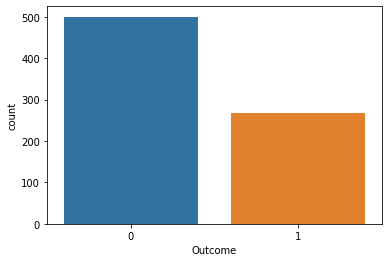

In [74]:
sns.countplot(pima_test['Outcome']);

In [75]:
sm = SMOTE(sampling_strategy = 1,k_neighbors = 5, random_state = 1)
x_smote, y_smote = sm.fit_resample(x_train, y_train.ravel())
model = LogisticRegression()
model.fit(x_smote, y_smote)
y_pred = model.predict(x_test)
print('Accuracy Score : {:.3f}%'.format(model.score(x_test, y_test)*100))
print('Confusion Matrix :\n {}'.format(confusion_matrix(y_test, y_pred)))

Accuracy Score : 79.221%
Confusion Matrix :
 [[117  29]
 [ 19  66]]


> We can see a significant increase in model accuracy by upsampling using SMOTE

### After Sampling

<AxesSubplot:ylabel='count'>

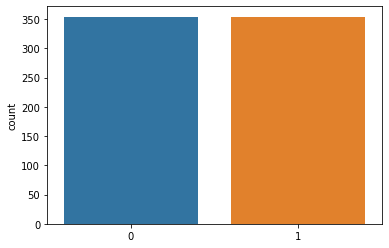

In [76]:
sns.countplot(y_smote)

## Using RandomUnderSampler

In [77]:
rus = RandomUnderSampler()
x_rus, y_rus = rus.fit_resample(x_train, y_train)
model.fit(x_rus, y_rus)
y_pred_rus = model.predict(x_test)
print('Accuracy Score : {:.3f}%'.format(model.score(x_test, y_test)*100))
print('Confusion Matrix :\n {}'.format(confusion_matrix(y_test, y_pred_rus)))

Accuracy Score : 78.788%
Confusion Matrix :
 [[114  32]
 [ 17  68]]


> We can see little decrease in model accuracy , Oversampling seems to be better option then no smapling or under sampling.

# Iterative Imputed Data with SMOTE resampling and Scaling using zscore

### Scaling

In [85]:
X_train = X_train.apply(zscore)
X_test = X_test.apply(zscore)

# Smoting

In [86]:
X_smote, Y_smote = sm.fit_resample(X_train, Y_train)

# Final Model

In [88]:
LR.fit(X_smote, Y_smote)
Y_pred = LR.predict(X_test)
print('Accuracy Score : {:.3f}%'.format(LR.score(X_test, Y_test)*100))
print('Confusion Matrix :\n {}'.format(confusion_matrix(Y_test,Y_pred)))

Accuracy Score : 80.952%
Confusion Matrix :
 [[122  24]
 [ 20  65]]


> We can see we have achieved around 81% Accuracy by imputing missing values with Iterative Imputer and Up sampling using SMOTE

# Using KFold Validation to check confidence level for our model

In [89]:
X = imputed_df.drop('Outcome', axis = 1)
Y = imputed_df['Outcome']

In [102]:
X = X.apply(zscore)
kf = KFold(n_splits = 10)
model = LogisticRegression()
results = cross_val_score(model, X, Y, cv = kf)
print(results)
print('Average Score : {:.3f}%'.format(results.mean()*100))
print('Std Score : {:.3f}%'.format(results.std()*100))

[0.7012987  0.81818182 0.76623377 0.67532468 0.77922078 0.77922078
 0.81818182 0.83116883 0.72368421 0.80263158]
Average Score : 76.951%
Std Score : 5.046%


> Average Score is around 77% with 5 % Std means its 95% confidence level is between 71% and 82%

# Bootstrap Sampling

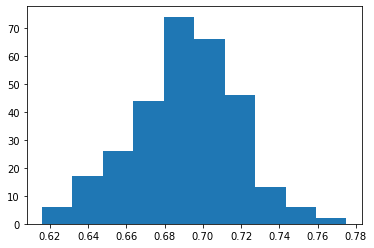

95.0% Confidence , 60.0% and 74.4%


In [107]:
imputed_df1 = imputed_df.copy()
imputed_df1.iloc[:, 0 : -1] = imputed_df1.iloc[:, 0 : -1].apply(zscore)
values = imputed_df1.values
n_iteration = 300
stats = []
for i in range(n_iteration):
  # preprARE train test
    train = resample(values)
    test  = np.array([x for x in values if x.tolist() not in train.tolist()])
  # fit model
    model = DecisionTreeClassifier()
    model.fit(train[:, : -1], train[:, -1])
  # Evaluate Model
    pred = model.predict(test[:, : -1])
    score = accuracy_score(test[:,-1], pred)
    stats.append(score)
    
plt.hist(stats)
plt.show()
# Confidence intervals
alpha = 0.95 
p = ((1- alpha)/2)*100
lower = max(0, np.percentile(stats, p))
p =  (alpha + ((1- alpha)/2))*100
upper = min(1, np.percentile(stats, p))
print(f'{alpha * 100}% Confidence , {round(lower, 1) * 100}% and {round(upper, 3) * 100}%')

> With bootstrap smapling model giving accuracy between 60 - 74 % 95% of the time